**** Predict users weekly workout amount ****

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import datetime
from datetime import date
import time
import math
import copy
from collections import Counter

from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn import svm
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
import warnings
warnings.filterwarnings('ignore')

We begin with reading the users workout data

In [3]:
df_workout = pd.read_csv('workouts data - full.csv',low_memory=False)

Timing in the app is given in epoch, we have to translate the epoch time to standart time and insert the user's given time zone

In [4]:
def ConvertEpochToTime(epoch):
    if epoch != epoch:
        return np.nan
#     d = time.strftime("%d %m %Y", time.gmtime(epoch/1000)) #GMT
    return datetime.datetime.utcfromtimestamp(epoch/1000).replace(tzinfo=datetime.timezone.utc)

def AddTimezoneDelay(hoursDelay):
    if hoursDelay  != hoursDelay:
        return datetime.timedelta(hours=0)
    return datetime.timedelta(hours=hoursDelay)

***We have to go over each user and count it's workouts per week for the entire given time he used the app, we then train numerous models to predict the amount of workout each user will workout the next week***

In [5]:
user_list = df_workout.userid.unique()

In [6]:
user_workout_amount = Counter(df_workout.userid)

In order to be able to make a better estimation, we decided to divide the users into several groups, by training different model on each group better result will be acheived.

The motivation behind clustering the data to groups of similar behaviour users is that they acts similar and therefore probably can belong to the same decision model.

In [7]:
def divideUsersToLists(user_workout_amount, user_list, lower_thr, upper_thr):
    valid_user_dict = dict()
    for current_user in user_list:
        current_workout = user_workout_amount[current_user]
        if (current_workout >= lower_thr) and (current_workout < upper_thr):
            valid_user_dict[current_user] = current_workout
    return valid_user_dict

Text(0.5,1,"Histogram for different users' workout amount")

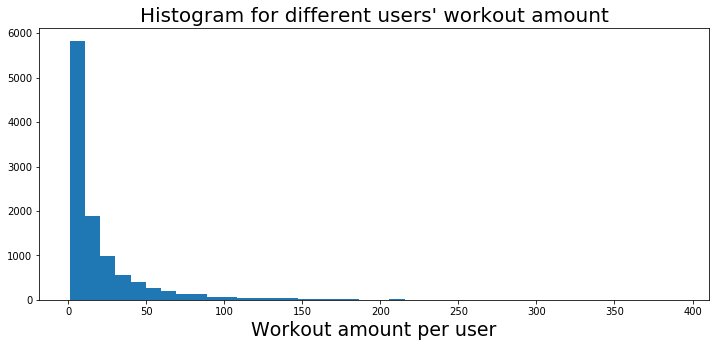

In [12]:
#Check what are the workouts amount of the users
plt.figure(figsize=[12,5])
plt.hist(list(user_workout_amount.values()),bins=40)
plt.xlabel("Workout amount per user",fontsize=19)
plt.title("Histogram for different users' workout amount",fontsize=20)


**We can see that there is almost 6k users that have had less then 10 workouts!
We will now delete them and plot the histogram again to see the results**

In [14]:
users_above_10_workouts = divideUsersToLists(user_workout_amount, user_list, 10, np.Inf)

Text(0.5,1,"Histogram for different users with more then 10 workouts' workout amount")

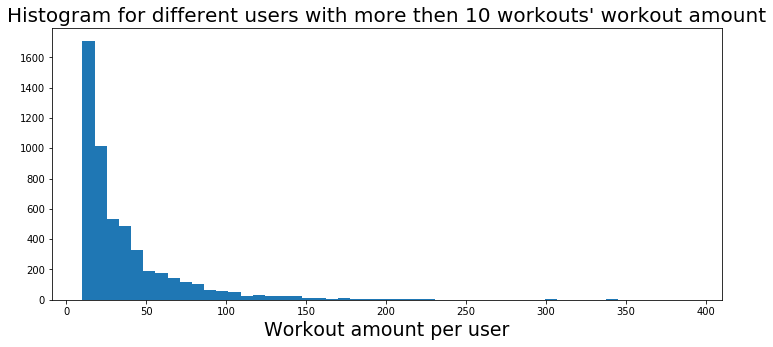

In [15]:
#Check what are the workouts amount of the users
plt.figure(figsize=[12,5])
plt.hist(list(users_above_10_workouts.values()),bins=50)
plt.xlabel("Workout amount per user",fontsize=19)
plt.title("Histogram for different users with more then 10 workouts' workout amount",fontsize=20)




**Looking at the previous histogram we see that a reasonable grouping of the users will be:**
1. 10 - 30 Total workouts
2. 31 - 50 Total workouts
3. 51 - 100 Total workouts
4. 101+ Total workouts 


In [11]:
users_of_10to30_workouts = divideUsersToLists(user_workout_amount, user_list, 10, 30)
users_of_31to50_workouts = divideUsersToLists(user_workout_amount, user_list, 31, 50)
users_of_51to100_workouts = divideUsersToLists(user_workout_amount, user_list, 51, 100)
users_of_100p_workouts = divideUsersToLists(user_workout_amount, user_list, 101, np.inf)

**Now what we got left is to run the workout by date count code**

*** Users of 100+ workouts Data ***

In [12]:
data_100p = []
labels_100p = []

user_list = list(users_of_100p_workouts.keys())
for current_user in range(0,len(user_list)):
    user_workouts = df_workout[df_workout.userid==user_list[current_user]]
    user_workouts["workout_date_UTC0"] = user_workouts.starttimeepoch.apply(ConvertEpochToTime)
    user_workouts["timezone_timestamp"] = user_workouts.timezone.apply(AddTimezoneDelay)
    user_workouts["workout_date"] = user_workouts.workout_date_UTC0 + user_workouts.timezone_timestamp
    user_workouts['workout_date'] = pd.to_datetime(user_workouts.workout_date)
    user_workouts = user_workouts.sort_values(by='workout_date')
    T = user_workouts.workout_date
    T = T[T==T] #Remove all NaT entries
    if len(T) < 2:
        continue
    first = T[T.index[0]]
    last = T[T.index[-1]] 

    # first = user_workouts.get_value(user_workouts.workout_date.index[0],'VALUE')
    date_range = pd.date_range(start=first, end=last, freq='D')
    workout_dates = list()
    for dt in T:
        try:
            workout_dates.append(datetime.date(dt.year, dt.month, dt.day))
        except:
            continue
            #starttimeepoch does not exist
    # workout_counter = 0
    cummulative = list()
    day_index = 0
    workout_counter = 0
    for d in date_range:
        day_index = day_index + 1
        d = datetime.date(d.year, d.month, d.day)
        if d in workout_dates:
            workout_counter = workout_counter + 1
        if day_index == 7: 
            cummulative.append(workout_counter)
            day_index = 0
            workout_counter = 0
    ser = pd.Series(cummulative)

    if len(cummulative) < 9:
        continue
    
    for i in range(8,len(cummulative)-1):
        data_100p.append(ser[i-8:i])
        labels_100p.append(ser[i+1])

In [13]:
data_100p = np.asarray(data_100p)
labels_100p = np.asarray(labels_100p)

In [14]:
data_100p_pd = pd.DataFrame(data=data_100p)
labels_100p_pd = pd.DataFrame(data=labels_100p)

In [15]:
data_100p_pd.to_csv('users_100p_weekly_twomonth_data.csv')
labels_100p_pd.to_csv('users_100p_weekly_twomonth_labels.csv')

***Users of 51 to 100 workouts Data ***

In [16]:
data_51to100 = []
labels_51to100 = []

user_list = list(users_of_51to100_workouts.keys())
for current_user in range(0,len(user_list)):
    user_workouts = df_workout[df_workout.userid==user_list[current_user]]
    user_workouts["workout_date_UTC0"] = user_workouts.starttimeepoch.apply(ConvertEpochToTime)
    user_workouts["timezone_timestamp"] = user_workouts.timezone.apply(AddTimezoneDelay)
    user_workouts["workout_date"] = user_workouts.workout_date_UTC0 + user_workouts.timezone_timestamp
    user_workouts['workout_date'] = pd.to_datetime(user_workouts.workout_date)
    user_workouts = user_workouts.sort_values(by='workout_date')
    T = user_workouts.workout_date
    T = T[T==T] #Remove all NaT entries
    if len(T) < 2:
        continue
    first = T[T.index[0]]
    last = T[T.index[-1]] 

    # first = user_workouts.get_value(user_workouts.workout_date.index[0],'VALUE')
    date_range = pd.date_range(start=first, end=last, freq='D')
    workout_dates = list()
    for dt in T:
        try:
            workout_dates.append(datetime.date(dt.year, dt.month, dt.day))
        except:
            continue
            #starttimeepoch does not exist
    # workout_counter = 0
    cummulative = list()
    day_index = 0
    workout_counter = 0
    for d in date_range:
        day_index = day_index + 1
        d = datetime.date(d.year, d.month, d.day)
        if d in workout_dates:
            workout_counter = workout_counter + 1
        if day_index == 7: 
            cummulative.append(workout_counter)
            day_index = 0
            workout_counter = 0
    ser = pd.Series(cummulative)

    if len(cummulative) < 9:
        continue
    
    for i in range(8,len(cummulative)-1):
        data_51to100.append(ser[i-8:i])
        labels_51to100.append(ser[i+1])

In [17]:
data_51to100 = np.asarray(data_51to100)
labels_51to100 = np.asarray(labels_51to100)

In [18]:
data_51to100_pd = pd.DataFrame(data=data_51to100)
labels_51to100_pd = pd.DataFrame(data=labels_51to100)

In [19]:
data_51to100_pd.to_csv('users_51to100_weekly_twomonth_data.csv')
labels_51to100_pd.to_csv('users_51to100_weekly_twomonth_labels.csv')

*** Users of 31 to 50 workouts Data ***

In [20]:
data_31to50 = []
labels_31to50 = []

user_list = list(users_of_31to50_workouts.keys())
for current_user in range(0,len(user_list)):
    user_workouts = df_workout[df_workout.userid==user_list[current_user]]
    user_workouts["workout_date_UTC0"] = user_workouts.starttimeepoch.apply(ConvertEpochToTime)
    user_workouts["timezone_timestamp"] = user_workouts.timezone.apply(AddTimezoneDelay)
    user_workouts["workout_date"] = user_workouts.workout_date_UTC0 + user_workouts.timezone_timestamp
    user_workouts['workout_date'] = pd.to_datetime(user_workouts.workout_date)
    user_workouts = user_workouts.sort_values(by='workout_date')
    T = user_workouts.workout_date
    T = T[T==T] #Remove all NaT entries
    if len(T) < 2:
        continue
    first = T[T.index[0]]
    last = T[T.index[-1]] 

    # first = user_workouts.get_value(user_workouts.workout_date.index[0],'VALUE')
    date_range = pd.date_range(start=first, end=last, freq='D')
    workout_dates = list()
    for dt in T:
        try:
            workout_dates.append(datetime.date(dt.year, dt.month, dt.day))
        except:
            continue
            #starttimeepoch does not exist
    # workout_counter = 0
    cummulative = list()
    day_index = 0
    workout_counter = 0
    for d in date_range:
        day_index = day_index + 1
        d = datetime.date(d.year, d.month, d.day)
        if d in workout_dates:
            workout_counter = workout_counter + 1
        if day_index == 7: 
            cummulative.append(workout_counter)
            day_index = 0
            workout_counter = 0
    ser = pd.Series(cummulative)

    if len(cummulative) < 9:
        continue
    
    for i in range(8,len(cummulative)-1):
        data_31to50.append(ser[i-8:i])
        labels_31to50.append(ser[i+1])

In [21]:
data_31to50 = np.asarray(data_31to50)
labels_31to50 = np.asarray(labels_31to50)

In [22]:
data_31to50_pd = pd.DataFrame(data=data_31to50)
labels_31to50_pd = pd.DataFrame(data=labels_31to50)

In [23]:
data_31to50_pd.to_csv('users_31to50_weekly_twomonth_data.csv')
labels_31to50_pd.to_csv('users_31to50_weekly_twomonth_labels.csv')

*** Users of 10 to 30 workouts Data ***

In [24]:
data_10to30 = []
labels_10to30 = []

user_list = list(users_of_10to30_workouts.keys())
for current_user in range(0,len(user_list)):
    user_workouts = df_workout[df_workout.userid==user_list[current_user]]
    user_workouts["workout_date_UTC0"] = user_workouts.starttimeepoch.apply(ConvertEpochToTime)
    user_workouts["timezone_timestamp"] = user_workouts.timezone.apply(AddTimezoneDelay)
    user_workouts["workout_date"] = user_workouts.workout_date_UTC0 + user_workouts.timezone_timestamp
    user_workouts['workout_date'] = pd.to_datetime(user_workouts.workout_date)
    user_workouts = user_workouts.sort_values(by='workout_date')
    T = user_workouts.workout_date
    T = T[T==T] #Remove all NaT entries
    if len(T) < 2:
        continue
    first = T[T.index[0]]
    last = T[T.index[-1]] 

    # first = user_workouts.get_value(user_workouts.workout_date.index[0],'VALUE')
    date_range = pd.date_range(start=first, end=last, freq='D')
    workout_dates = list()
    for dt in T:
        try:
            workout_dates.append(datetime.date(dt.year, dt.month, dt.day))
        except:
            continue
            #starttimeepoch does not exist
    # workout_counter = 0
    cummulative = list()
    day_index = 0
    workout_counter = 0
    for d in date_range:
        day_index = day_index + 1
        d = datetime.date(d.year, d.month, d.day)
        if d in workout_dates:
            workout_counter = workout_counter + 1
        if day_index == 7: 
            cummulative.append(workout_counter)
            day_index = 0
            workout_counter = 0
    ser = pd.Series(cummulative)

    if len(cummulative) < 9:
        continue
    
    for i in range(8,len(cummulative)-1):
        data_10to30.append(ser[i-8:i])
        labels_10to30.append(ser[i+1])

In [25]:
data_10to30 = np.asarray(data_10to30)
labels_10to30 = np.asarray(labels_10to30)

In [26]:
data_10to30_pd = pd.DataFrame(data=data_10to30)
labels_10to30_pd = pd.DataFrame(data=labels_10to30)

In [27]:
data_10to30_pd.to_csv('users_10to30_weekly_twomonth_data.csv')
labels_10to30_pd.to_csv('users_10to30_weekly_twomonth_labels.csv')

**Note:** Once we ran the entire code, result analysis can be achived from here in order to avoid repeated computations.

Read entire data and transfer to array

In [29]:
## 100p
data_100p_pd = pd.read_csv('users_100p_weekly_twomonth_data.csv',low_memory=False)
data_100p_pd = data_100p_pd.drop(columns='Unnamed: 0')

labels_100p_pd = pd.read_csv('users_100p_weekly_twomonth_labels.csv',low_memory=False)
labels_100p_pd = labels_100p_pd.drop(columns='Unnamed: 0')

## 51 to 100
data_51to100_pd = pd.read_csv('users_51to100_weekly_twomonth_data.csv',low_memory=False)
data_51to100_pd = data_51to100_pd.drop(columns='Unnamed: 0')

labels_51to100_pd = pd.read_csv('users_51to100_weekly_twomonth_labels.csv',low_memory=False)
labels_51to100_pd = labels_51to100_pd.drop(columns='Unnamed: 0')

## 31 to 50
data_31to50_pd = pd.read_csv('users_31to50_weekly_twomonth_data.csv',low_memory=False)
data_31to50_pd = data_31to50_pd.drop(columns='Unnamed: 0')

labels_31to50_pd = pd.read_csv('users_31to50_weekly_twomonth_labels.csv',low_memory=False)
labels_31to50_pd = labels_31to50_pd.drop(columns='Unnamed: 0')

## 10 to 30
data_10to30_pd = pd.read_csv('users_10to30_weekly_twomonth_data.csv',low_memory=False)
data_10to30_pd = data_10to30_pd.drop(columns='Unnamed: 0')

labels_10to30_pd = pd.read_csv('users_10to30_weekly_twomonth_labels.csv',low_memory=False)
labels_10to30_pd = labels_10to30_pd.drop(columns='Unnamed: 0')

In [30]:
## 100p
data_100p = np.asarray(data_100p_pd)
labels_100p = np.asarray(labels_100p_pd)

## 51 to 100
data_51to100 = np.asarray(data_51to100_pd)
labels_51to100 = np.asarray(labels_51to100_pd)

## 31 to 50
data_31to50 = np.asarray(data_31to50_pd)
labels_31to50 = np.asarray(labels_31to50_pd)

## 10 to 30
data_10to30 = np.asarray(data_10to30_pd)
labels_10to30 = np.asarray(labels_10to30_pd)

*** We divide the data for each dataset to train set (80%) and test set (20%), we then run linear regression and print the results ***

** We plot a small section of the predicted and real data to check the general behaviour, as well as the estimation error histogram **

In [31]:
## 100p
X_train_100p, X_test_100p, y_train_100p, y_test_100p = train_test_split(data_100p, labels_100p, test_size=.2)

# Create linear regression object
regr_100p = linear_model.LinearRegression()

# Train the model using the training sets
regr_100p.fit(X_train_100p, y_train_100p)

# Make predictions using the testing set
y_predictions_100p_regr = regr_100p.predict(X_test_100p)

# The coefficients
print('Coefficients: \n', regr_100p.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test_100p,y_predictions_100p_regr))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test_100p, y_predictions_100p_regr))

Coefficients: 
 [[0.02609159 0.02056458 0.02082629 0.04502974 0.04077542 0.0842879
  0.11852025 0.31702575]]
Mean squared error: 2.17
Variance score: 0.31


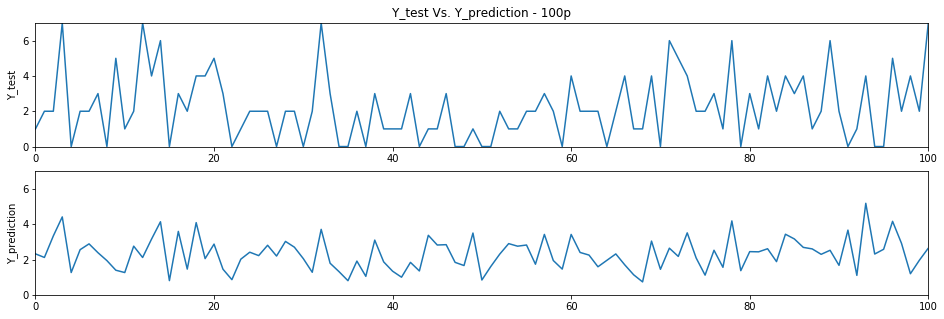

In [41]:
plt.figure(figsize=[16,5])
plt.subplot(2, 1, 1)
plt.plot(range(0,len(y_test_100p)), y_test_100p)
plt.title('Y_test Vs. Y_prediction - 100p')
plt.ylabel('Y_test')
plt.xlim([0,100])
plt.ylim([0,7])
plt.subplot(2, 1, 2)
plt.plot(range(0,len(y_predictions_100p_regr)), y_predictions_100p_regr)
plt.ylabel('Y_prediction')
plt.xlim([0,100])
plt.ylim([0,7])
plt.show()

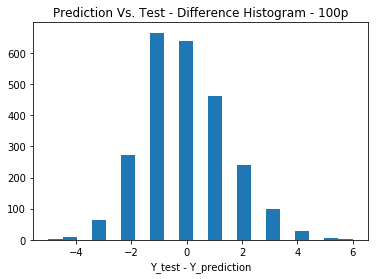

In [53]:
plt.hist(y_test_100p - y_predictions_100p_regr.round(),bins=21)
plt.title('Prediction Vs. Test - Difference Histogram - 100p')
plt.xlabel('Y_test - Y_prediction')
plt.show()

In [33]:
## 51 to 100
X_train_51to100, X_test_51to100, y_train_51to100, y_test_51to100 = train_test_split(data_51to100, labels_51to100, test_size=.2)

# Create linear regression object
regr_51to100 = linear_model.LinearRegression()

# Train the model using the training sets
regr_51to100.fit(X_train_51to100, y_train_51to100)

# Make predictions using the testing set
y_predictions_51to100_regr = regr_51to100.predict(X_test_51to100)

# The coefficients
print('Coefficients: \n', regr_51to100.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test_51to100,y_predictions_51to100_regr))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test_51to100, y_predictions_51to100_regr))

Coefficients: 
 [[0.0098606  0.02012497 0.01528869 0.02958507 0.04438866 0.07493463
  0.10991709 0.29341058]]
Mean squared error: 1.30
Variance score: 0.18


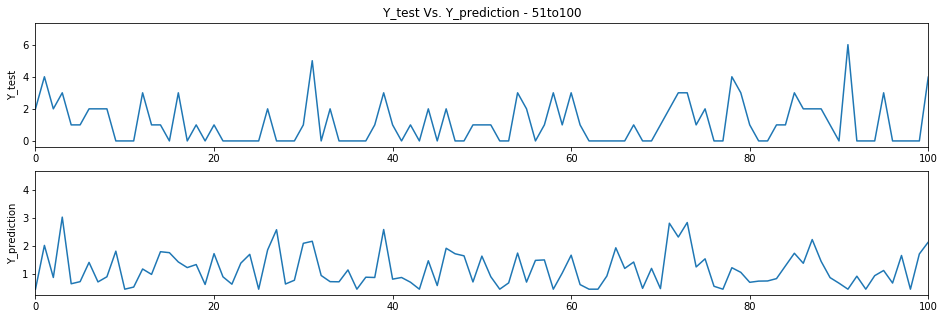

In [34]:
plt.figure(figsize=[16,5])
plt.subplot(2, 1, 1)
plt.plot(range(0,len(y_test_51to100)), y_test_51to100)
plt.title('Y_test Vs. Y_prediction - 51to100')
plt.ylabel('Y_test')
plt.xlim([0,100])
plt.ylim([0,7])
plt.subplot(2, 1, 2)
plt.plot(range(0,len(y_predictions_51to100_regr)), y_predictions_51to100_regr)
plt.ylabel('Y_prediction')
plt.xlim([0,100])
plt.ylim([0,7])
plt.show()

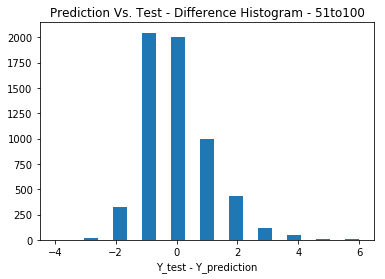

In [54]:
plt.hist(y_test_51to100 - y_predictions_51to100_regr.round(),bins=21)
plt.title('Prediction Vs. Test - Difference Histogram - 51to100')
plt.xlabel('Y_test - Y_prediction')
plt.show()

In [35]:
## 31 to 50
X_train_31to50, X_test_31to50, y_train_31to50, y_test_31to50 = train_test_split(data_31to50, labels_31to50, test_size=.2)

# Create linear regression object
regr_31to50 = linear_model.LinearRegression()

# Train the model using the training sets
regr_31to50.fit(X_train_31to50, y_train_31to50)

# Make predictions using the testing set
y_predictions_31to50_regr = regr_31to50.predict(X_test_31to50)

# The coefficients
print('Coefficients: \n', regr_31to50.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test_31to50,y_predictions_31to50_regr))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test_31to50, y_predictions_31to50_regr))

Coefficients: 
 [[0.01123692 0.00727991 0.01040604 0.01927952 0.02160725 0.05520421
  0.10444623 0.25333252]]
Mean squared error: 0.79
Variance score: 0.14


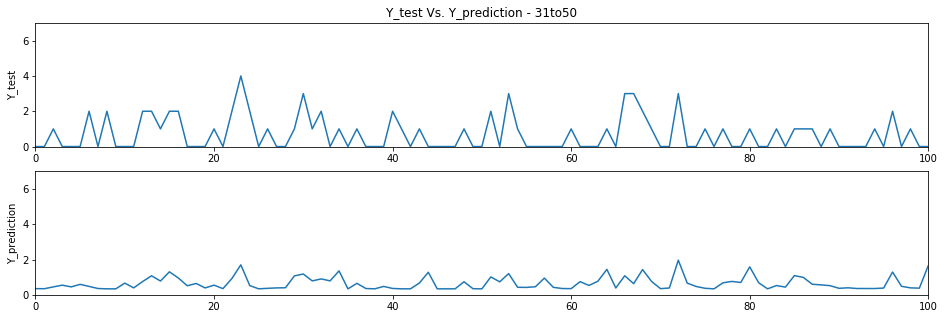

In [39]:
plt.figure(figsize=[16,5])
plt.subplot(2, 1, 1)
plt.plot(range(0,len(y_test_31to50)), y_test_31to50)
plt.title('Y_test Vs. Y_prediction - 31to50')
plt.ylabel('Y_test')
plt.xlim([0,100])
plt.ylim([0,7])
plt.subplot(2, 1, 2)
plt.plot(range(0,len(y_predictions_31to50_regr)), y_predictions_31to50_regr)
plt.ylabel('Y_prediction')
plt.xlim([0,100])
plt.ylim([0,7])
plt.show()

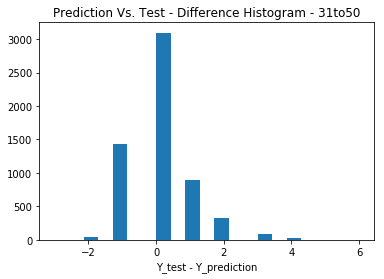

In [55]:
plt.hist(y_test_31to50 - y_predictions_31to50_regr.round(),bins=21)
plt.title('Prediction Vs. Test - Difference Histogram - 31to50')
plt.xlabel('Y_test - Y_prediction')
plt.show()

In [37]:
## 10 to 30
X_train_10to30, X_test_10to30, y_train_10to30, y_test_10to30 = train_test_split(data_10to30, labels_10to30, test_size=.2)

# Create linear regression object
regr_10to30 = linear_model.LinearRegression()

# Train the model using the training sets
regr_10to30.fit(X_train_10to30, y_train_10to30)

# Make predictions using the testing set
y_predictions_10to30_regr = regr_10to30.predict(X_test_10to30)

# The coefficients
print('Coefficients: \n', regr_10to30.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test_10to30,y_predictions_10to30_regr))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test_10to30, y_predictions_10to30_regr))

Coefficients: 
 [[ 0.00684986 -0.00119289  0.00448187  0.02174676  0.03158235  0.041136
   0.07487439  0.19231807]]
Mean squared error: 0.40
Variance score: 0.08


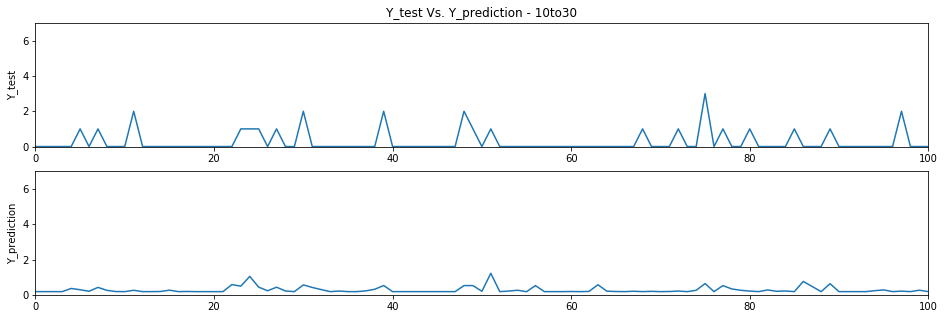

In [40]:
plt.figure(figsize=[16,5])
plt.subplot(2, 1, 1)
plt.plot(range(0,len(y_test_10to30)), y_test_10to30)
plt.title('Y_test Vs. Y_prediction - 10to30')
plt.ylabel('Y_test')
plt.xlim([0,100])
plt.ylim([0,7])
plt.subplot(2, 1, 2)
plt.plot(range(0,len(y_predictions_10to30_regr)), y_predictions_10to30_regr)
plt.ylabel('Y_prediction')
plt.xlim([0,100])
plt.ylim([0,7])
plt.show()

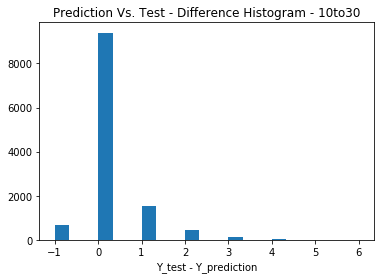

In [56]:
plt.hist(y_test_10to30 - y_predictions_10to30_regr.round(),bins=21)
plt.title('Prediction Vs. Test - Difference Histogram - 10to30')
plt.xlabel('Y_test - Y_prediction')
plt.show()

*** Conclusions: ***
1. For the 100+ workouts data: <br/>
    1.1. We can see that the MSE is 2.17 days per week. <br/>
    1.2. Approximatly 70% of the predicted data lies within +-1day error.<br/>
    1.3. The prediction fails in the "busy" weeks of 5+ workouts.<br/>
    
2. For the 51 - 100 workouts data: <br/>
    2.1. We can see that the MSE is 1.3 days per week. <br/>
    2.2. Approximatly 85% of the predicted data lies withing +-1day error. <br/>
    2.3. The prediction perform better in "busy" weeks, although it is less common for this dataset. <br/>
   
3. For the 31 - 50 workouts data: <br/>
    3.1. We can see that the MSE is 0.79 days per week. <br/>
    3.2. Approximatly 52% of the predicted data is accurate (0 days error) and 93% of the predicted data lies within +-1day error. <br/>
    
4. For the 11 - 30 workouts data: <br/>
    4.1. We can see that the MSE is 0.4 days per week. <br/>
    3.2. Approximatly 83% of the predicted data is accurate (0 days error) and 96% of the predicted data lies within +-1day error. <br/>

**Note:** We explain the decrease in MSE for less workouts amount because of the increase in data, we have much more data in the 11-30 workouts dataset then in the 100+ workouts dataset and therefore the model fits and estimate the results better.